### I make all imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import pyro
import pyro.distributions as dist
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
from pyro.nn import PyroModule
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.nn import PyroSample

In [3]:
import matplotlib.pyplot as plt

In [4]:
import numpy as np

In [5]:
from sklearn.datasets import make_moons

### I dowload all datasets

In [12]:
x, y = make_moons(n_samples=1000, noise=0.4)

In [13]:
x = torch.from_numpy(x.astype(np.float32))
y = torch.from_numpy(y.astype(np.float32))

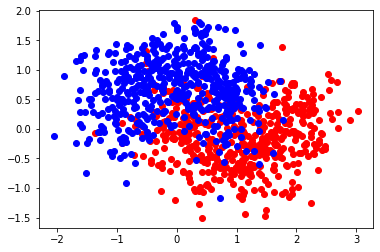

In [14]:
plt.scatter(x[y>0][:, 0], x[y>0][:, 1], color="red")
plt.scatter(x[y<1][:, 0], x[y<1][:, 1], color="blue")

### Now I create a probabilitsti model

- Notice that I extend PyroModule, which in turn extends torch.nn.Module
- I use PyroModule[nn.Linear] which allows to make a prob layers

In [15]:
class BayesianNet(PyroModule):
    def __init__(self, layers):
        super(BayesianNet, self).__init__()
        self.num_layers = layers
        self.layers = []
        
        for i in range(len(self.num_layers)-2):   
            layer = PyroModule[nn.Linear](self.num_layers[i], self.num_layers[i+1])
            layer.weight = PyroSample(dist.Normal(0., 1).expand([self.num_layers[i+1], self.num_layers[i]]).to_event(2))
            layer.bias = PyroSample(dist.Normal(0., 1).expand([self.num_layers[i+1]]).to_event(1))
            self.layers.append(layer)
            
        ### I need to put the output layer apart because the activation function is in general different
        self.output_layer = PyroModule[nn.Linear](self.num_layers[-2], self.num_layers[-1])
        self.output_layer.weight =  PyroSample(dist.Normal(0., 1).expand([self.num_layers[-1], self.num_layers[-2]]).to_event(2))
        self.output_layer.bias = PyroSample(dist.Normal(0., 1).expand([self.num_layers[-1]]).to_event(1))


            
    def forward(self, x, y=None):
        out = x
        for i in range(len(self.layers)):   
            out = self.layers[i](out)
            out = F.relu(out)
            
        #### The layers before give the mean
        logit = self.output_layer(out).squeeze(-1)
        
        
        ## in case I provide a y I want to condition on data
        with pyro.plate("data", x.shape[0]):
            obs=pyro.sample("obs", dist.Bernoulli(logits=logit), obs=y)
        
        return torch.sigmoid(logit)
        

### Now I create the model and the guide

In [16]:
model = BayesianNet([2, 10, 1])

In [17]:
guide = AutoDiagonalNormal(model)

In [18]:
optim = Adam({"lr":0.01})

In [19]:
svi = SVI(model, guide, optim=optim, loss=Trace_ELBO())

In [20]:
epochs = 10000

In [21]:
for j in range(epochs):
    
    loss = svi.step(x, y)
    if j%100==0:
        print("loss:  {}".format(loss))
    
    

loss:  750.7851405143738
loss:  434.41373097896576
loss:  431.5043029785156
loss:  421.2393282651901
loss:  418.7300981283188
loss:  422.13898277282715
loss:  419.23735105991364
loss:  417.4261951446533
loss:  426.8648874759674
loss:  422.4546768665314
loss:  416.4094443321228
loss:  401.6975724697113
loss:  410.79229950904846
loss:  398.27391397953033
loss:  391.8733458518982
loss:  407.7106302976608
loss:  391.69763910770416
loss:  394.43161046504974
loss:  375.9248490333557
loss:  394.92998188734055
loss:  371.34467899799347
loss:  384.68381547927856
loss:  386.35168623924255
loss:  373.2204316854477
loss:  373.80278289318085
loss:  393.55834913253784
loss:  378.87640833854675
loss:  371.85608291625977
loss:  373.0295089483261
loss:  377.1809446811676
loss:  371.86499214172363
loss:  375.45564246177673
loss:  385.81095719337463
loss:  373.21375501155853
loss:  380.019739151001
loss:  371.7955937385559
loss:  377.2485752105713
loss:  370.53560066223145
loss:  370.0053679943085
loss: 

In [22]:
guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name),  pyro.param(name).shape)

AutoDiagonalNormal.loc Parameter containing:
tensor([-2.5412, -0.5525, -0.7767, -1.4348,  2.0016, -0.4872, -0.3443, -0.2222,
        -0.1992, -0.3486, -0.3028, -0.1923, -0.2408,  0.0170, -0.4059,  1.6117,
        -0.3433, -0.1980, -0.2256, -0.2293, -0.2744,  1.6312, -1.8592, -0.9302,
        -0.8550, -0.9599, -0.8834,  0.0595, -0.9968, -1.0190, -2.1836,  1.7591,
         2.2904,  0.0850, -0.0737, -0.0440,  0.1695, -0.9079, -0.0728, -0.0377,
        -1.3122]) torch.Size([41])
AutoDiagonalNormal.scale tensor([0.1845, 0.2175, 0.0714, 0.1206, 0.0556, 0.1655, 0.6143, 0.6975, 0.6294,
        0.7628, 0.6080, 0.8115, 0.6102, 0.7309, 0.1962, 0.2391, 0.5927, 0.7017,
        0.6260, 0.7374, 0.1017, 0.0610, 0.0767, 0.4701, 0.5362, 0.5606, 0.5616,
        0.1409, 0.5864, 0.5867, 0.1671, 0.0711, 0.2083, 0.4173, 0.4544, 0.4868,
        0.4877, 0.1178, 0.4649, 0.5323, 0.0910]) torch.Size([41])


In [23]:

guide.quantiles([0.25, 0.5, 0.75])

{'weight': [tensor([[-2.6656, -0.6992],
          [-0.8249, -1.5161],
          [ 1.9641, -0.5988],
          [-0.7587, -0.6927],
          [-0.6237, -0.8631],
          [-0.7129, -0.7396],
          [-0.6525, -0.4760],
          [-0.5382,  1.4504],
          [-0.7431, -0.6714],
          [-0.6479, -0.7267]]),
  tensor([[-2.5412, -0.5525],
          [-0.7767, -1.4348],
          [ 2.0016, -0.4872],
          [-0.3443, -0.2222],
          [-0.1992, -0.3486],
          [-0.3028, -0.1923],
          [-0.2408,  0.0170],
          [-0.4059,  1.6117],
          [-0.3433, -0.1980],
          [-0.2256, -0.2293]]),
  tensor([[-2.4167, -0.4058],
          [-0.7285, -1.3535],
          [ 2.0392, -0.3756],
          [ 0.0700,  0.2483],
          [ 0.2253,  0.1659],
          [ 0.1073,  0.3551],
          [ 0.1708,  0.5101],
          [-0.2736,  1.7730],
          [ 0.0564,  0.2753],
          [ 0.1966,  0.2681]])],
 'bias': [tensor([-0.3429,  1.5900, -1.9109, -1.2473, -1.2167, -1.3380, -1.2622, -0

In [24]:
from pyro.infer import Predictive

In [49]:
predictive = Predictive(model, guide=guide, num_samples=1000, return_sites=["obs", "_RETURN"])

In [50]:
res = predictive(x[0:3])

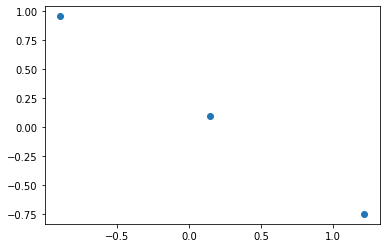

In [51]:
plt.scatter(x[0:3, 0], x[0:3, 1])

In [52]:
y[0:3]

tensor([1., 0., 1.])

In [53]:
res["obs"].shape

torch.Size([1000, 3])

(array([289.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 711.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

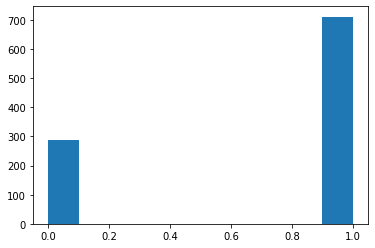

In [54]:
plt.hist(res["obs"][:, 0])

In [55]:
a = np.array([[0., 0.], [-1., 2], [1, -2]]).astype(np.float32)

In [56]:
We are tossing a coin, but we do not know if it is a fair coin, we want to establish the head probability (for a fair coin of course θ=0.5).res = predictive(torch.from_numpy(a))

(array([  1.,   1.,   2.,   1.,   1.,   0.,   4.,   5.,  15., 970.]),
 array([0.95044816, 0.95540315, 0.96035814, 0.96531314, 0.97026813,
        0.9752231 , 0.9801781 , 0.9851331 , 0.9900881 , 0.9950431 ,
        0.9999981 ], dtype=float32),
 <a list of 10 Patch objects>)

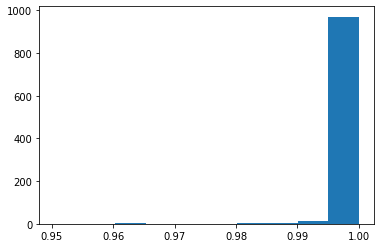

In [64]:
plt.hist(res["_RETURN"][:, 2])

In [61]:
res["_RETURN"][0:10, 0]

tensor([0.8352, 0.8490, 0.8012, 0.7917, 0.8438, 0.8103, 0.8382, 0.7790, 0.8090,
        0.8413])